A tutorial on simulating from msprime (TODO link) (advised) or the HMM of PSMC+.  

Last updated 21st December 2023. 

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import msprime 

plt.rcParams['figure.figsize'] = [12, 8] #flagfigsize
plt.rcParams.update({'font.size': 15})

## Simulation parameters

Arbitrarily, let's choose some parameters for the simulation:<br>
$\theta=4N\mu=0.005$<br>
$\rho=4Nr=0.001$<br>
$spread_1=0.05$<br>
$spread_2=50$<br>
$D=32$<br>
and a changing population size as shown in the below cell.

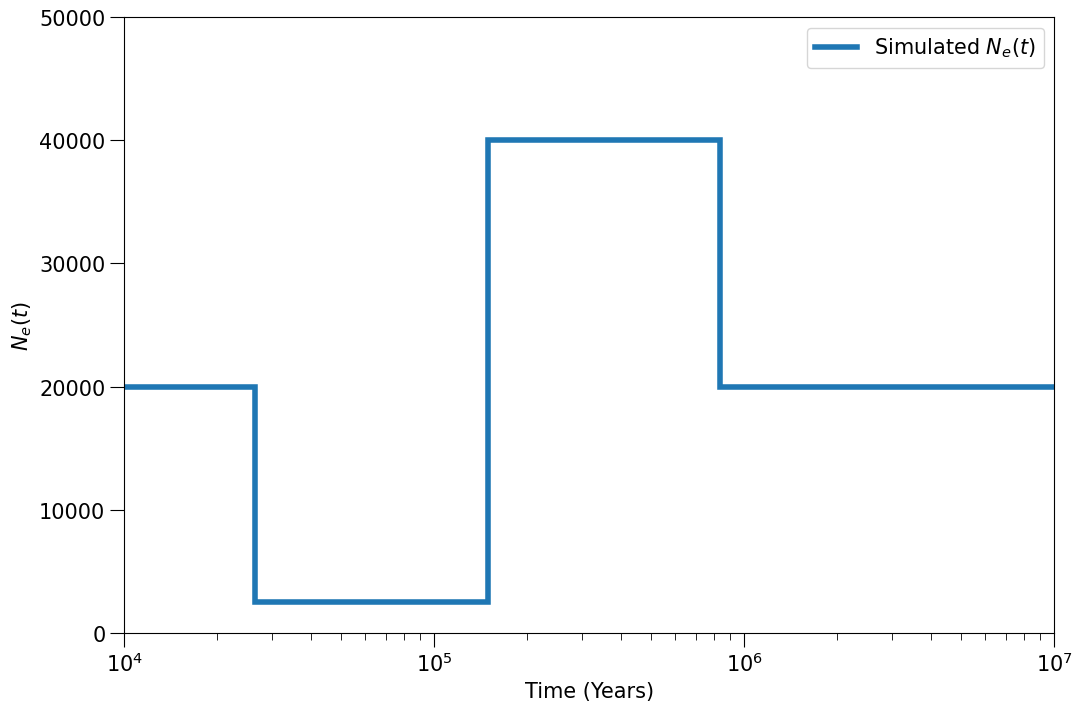

In [85]:
# function that describes the coalescent time boundaries
def time_intervals(D,spread_1,spread_2,final_T_factor=None):
    # D - int. Number of discrete time intervals
    # spread_1 - float. Describes spread of early time intervals
    # spread_2 - float. Describes spread of late time intervals

    T = [0]
    if final_T_factor is not None: # last boundary is a factor of second-to-last boundary
        for i in range(0,D-1):
            T.append( spread_1*np.exp( (i/D)*np.log(1 + spread_2/spread_1) - 1))
        T.append(T[-1]*final_T_factor) # append  large last tMRCA to represent infinity
    else: # last boundary follows the sequence
        for i in range(0,D):
            T.append( spread_1*np.exp( (i/D)*np.log(1 + spread_2/spread_1) - 1))
    T_np = np.array(T)
    return T_np

# function that writes mhs file
def write_mhs(pos,filename,chrom):
    # pos is index of hets
    # chrom is int
    current_chr = f'chr{chrom}'
    diff_pos = pos[1:] - pos[0:-1]
    SSPSS = np.concatenate(([pos[0]] ,diff_pos))
    gt = ['01']*len(pos)
    chr_label = [current_chr]*len(pos)

    with open(filename,'w') as f:
        lis=[chr_label,pos,SSPSS,gt]
        for x in zip(*lis):
            f.write("{0}\t{1}\t{2}\t{3}\n".format(*x))
    print(f'\tsaved mhs file to {filename}')
    return None

# function that writes coalescent data from msprime
def get_coal_data_arg(sim):
    tmrca_data = np.zeros(shape=(sim.get_num_trees(),3))
    index = 0
    for tree in sim.trees():
        tmrca_data[tree.index,0] = tree.index
        tmrca_data[tree.index,1] = tree.interval[1]
        tmrca_data[tree.index,2] = tree.time(tree.mrca(0,1))
    return tmrca_data


theta = 0.001
rho = 0.0001
spread_1 = 0.05
spread_2 = 50
D = 32
T_coalescent = time_intervals(D,spread_1,spread_2)
lambda_array = np.ones(D)
lambda_array[2:10] = 8

lambda_array[10:18] = 0.5

mu = 1.25e-08 
r=1e-08
gen = 29
N = theta/(4*mu) 
T_gens = T_coalescent*2*N
T_years = T_coalescent*2*N*gen


plt.stairs(edges=T_years,values=N/lambda_array,baseline=None,linewidth=4,label="Simulated $N_e(t)$")
plt.xscale('log')
plt.xlabel('Time (Years)')
plt.ylabel('$N_e(t)$')
plt.xlim(1e+04,1e+07)
plt.legend()
plt.ylim(0,50000)
plt.tick_params(axis='both', which='major', length=10)
plt.tick_params(axis='both', which='minor', length=5)

## Simulating from msprime



In [86]:
num_individuals=2
L = 1e+07
simulation_model = "hudson"
demography = msprime.Demography()
demography.add_population(name="human", initial_size=N)
for i in range(0,len(lambda_array)):
    demography.add_population_parameters_change(T_gens[i], initial_size=N*(1/lambda_array[i]), growth_rate=None, population="human") 
demography.sort_events()
debug = demography.debug()
sim = msprime.sim_ancestry(samples={"human": num_individuals},ploidy=1,demography=demography,sequence_length=L,model="hudson",recombination_rate=r)
msim =  msprime.sim_mutations(sim, rate=mu)
hets = np.array([int(np.rint(var.site.position)) for var in msim.variants() if var.genotypes[0]!=var.genotypes[1]])

outmhs = '/home/trc468/simulationsPSMCplus/sim231221_msprime_variants.mhs'
outcoal = '/home/trc468/simulationsPSMCplus/sim231221_msprime_coal.txt.gz'
write_mhs(hets,outmhs,'SIM')
tmrca_data = get_coal_data_arg(sim)
print(f'\tsaved coalescent data to {outcoal}')



	saved mhs file to /home/trc468/simulationsPSMCplus/sim231221_msprime_variants.mhs
	saved coalescent data to /home/trc468/simulationsPSMCplus/sim231221_msprime_coal.txt.gz


(1000000.0, 1200000.0)

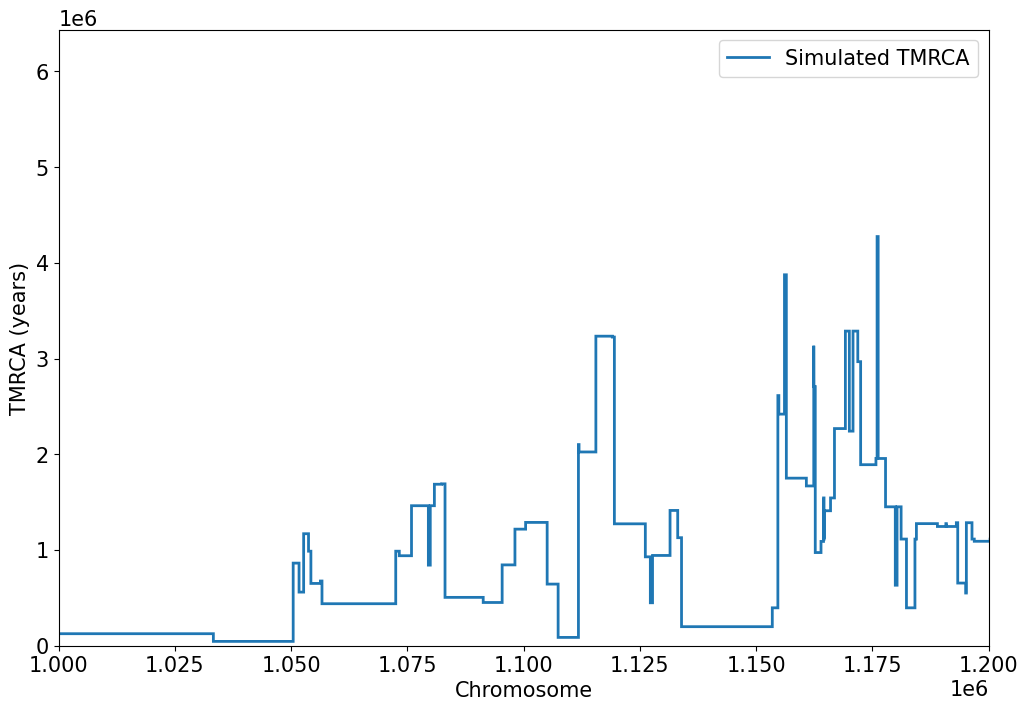

In [89]:
breakpoints=np.concatenate([[0],tmrca_data[:,1]])
plt.stairs(edges=breakpoints,values=tmrca_data[:,2]*gen,label="Simulated TMRCA",linewidth=2)
plt.xlabel('Chromosome')
plt.ylabel('TMRCA (years)')
plt.legend()
plt.xlim(1e+06,1.2e+06)

## Simulating from the HMM of PSMC+

Now I simulate from the HMM of PSMC+ (using the SMC' model). Are there any advantages to doing this, as opposed to msprime? Not really, but it might be a bit cleaner in terms of $\theta$ and $\rho$.<br> 
We can simulate directly from the command line. If your sequence length is long, this will take a while and I would recommend submitting to a compute farm.

In [4]:
seqlength = 1000000 # 1Mb sequence length 
lambda_A = ",".join([str(i) for i in lambda_array])
outmhs = '/home/trc468/simulationsPSMCplus/sim231221_variants.mhs'
outcoal = '/home/trc468/simulationsPSMCplus/sim231221_coal.txt.gz'
commandline = f"python /home/trc468/PSMCplus/simulate_HMM.py -D {D} -lambda_A {lambda_A} -theta {theta} -rho {rho} -spread_1 {spread_1} -spread_2 {spread_2} -L {seqlength} -o_mhs {outmhs} -o_coal {outcoal}"
!{commandline} 

D is 32
bin_size is 1
final_T_factor is False
lambda_A is 1.0,1.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
midpoint_emissions is False
midpoint_transitions is False
o_coal is /home/trc468/simulationsPSMCplus/sim231221_coal.txt.gz
o_mhs is /home/trc468/simulationsPSMCplus/sim231221_variants.mhs
recombnoexp is False
rho is 0.0001
seqlen is 1000000
spread_1 is 0.05
spread_2 is 50.0
theta is 0.001
	written mhs file to /home/trc468/simulationsPSMCplus/sim231221_variants.mhs
	written coaldata to /home/trc468/simulationsPSMCplus/sim231221_coal.txt.gz


The above took about 3.5 minutes on my laptop.

(400000.0, 1000000.0)

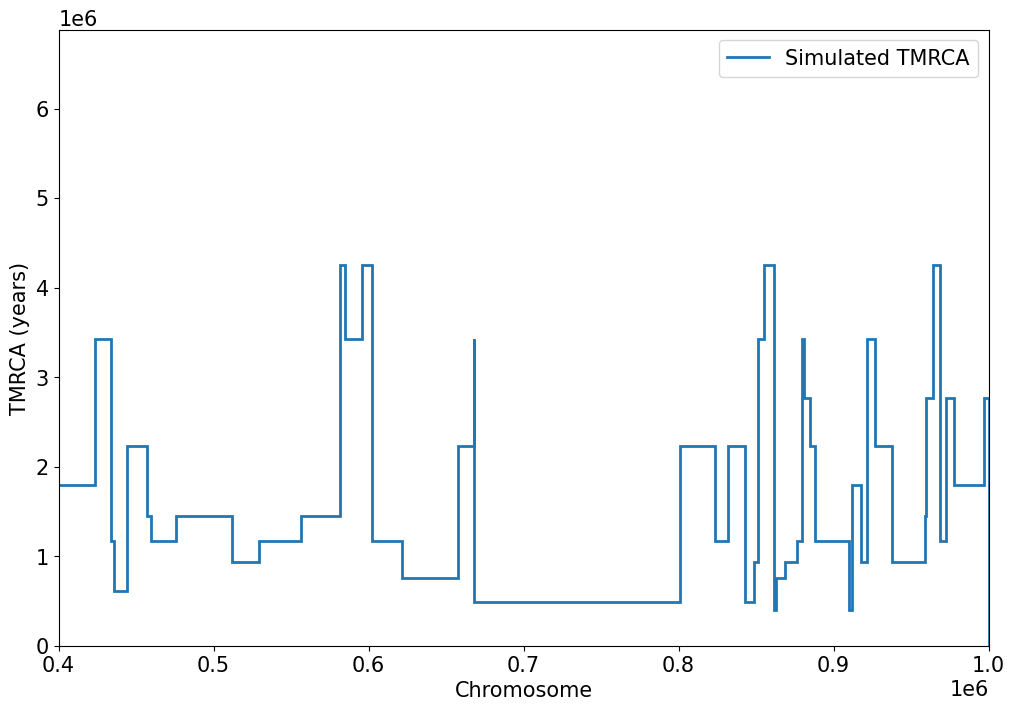

In [12]:
T_coalescent_ff_string = !zcat /home/trc468/simulationsPSMCplus/sim231221_coal.txt.gz | head # get time boundaries from file 
T_coalescent_ff = np.array([float(i) for i in T_coalescent_ff_string[0].split('= ')[1].split(',')])
T_coalescent_midpoints_ff = np.array( [(T_coalescent_ff[i]+T_coalescent_ff[i+1])/2 for i in range(0,len(T_coalescent_ff)-1)]) 

coaldata = np.loadtxt('/home/trc468/simulationsPSMCplus/sim231221_coal.txt.gz')
gen=29
mu = 1.25e-08
positions = np.concatenate([np.array(coaldata[:,0]),[coaldata[-1,1]]])
T_years_midpoints_ff = T_coalescent_midpoints_ff*2*(theta/(4*mu))*gen
TMRCAs = np.array([T_years_midpoints_ff[int(j)] for j in coaldata[:,2]])
plt.stairs(edges=positions[1:],values=TMRCAs[1:],label="Simulated TMRCA",linewidth=2)
plt.xlabel('Chromosome')
plt.ylabel('TMRCA (years)')
plt.legend()
plt.xlim(400000,1e+06)